In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from utils.preprocess import *
from utils.model import *

import torch
from torch.utils.data import Dataset, DataLoader

import pickle

## Step-by-Step Data Preprocessing Demo

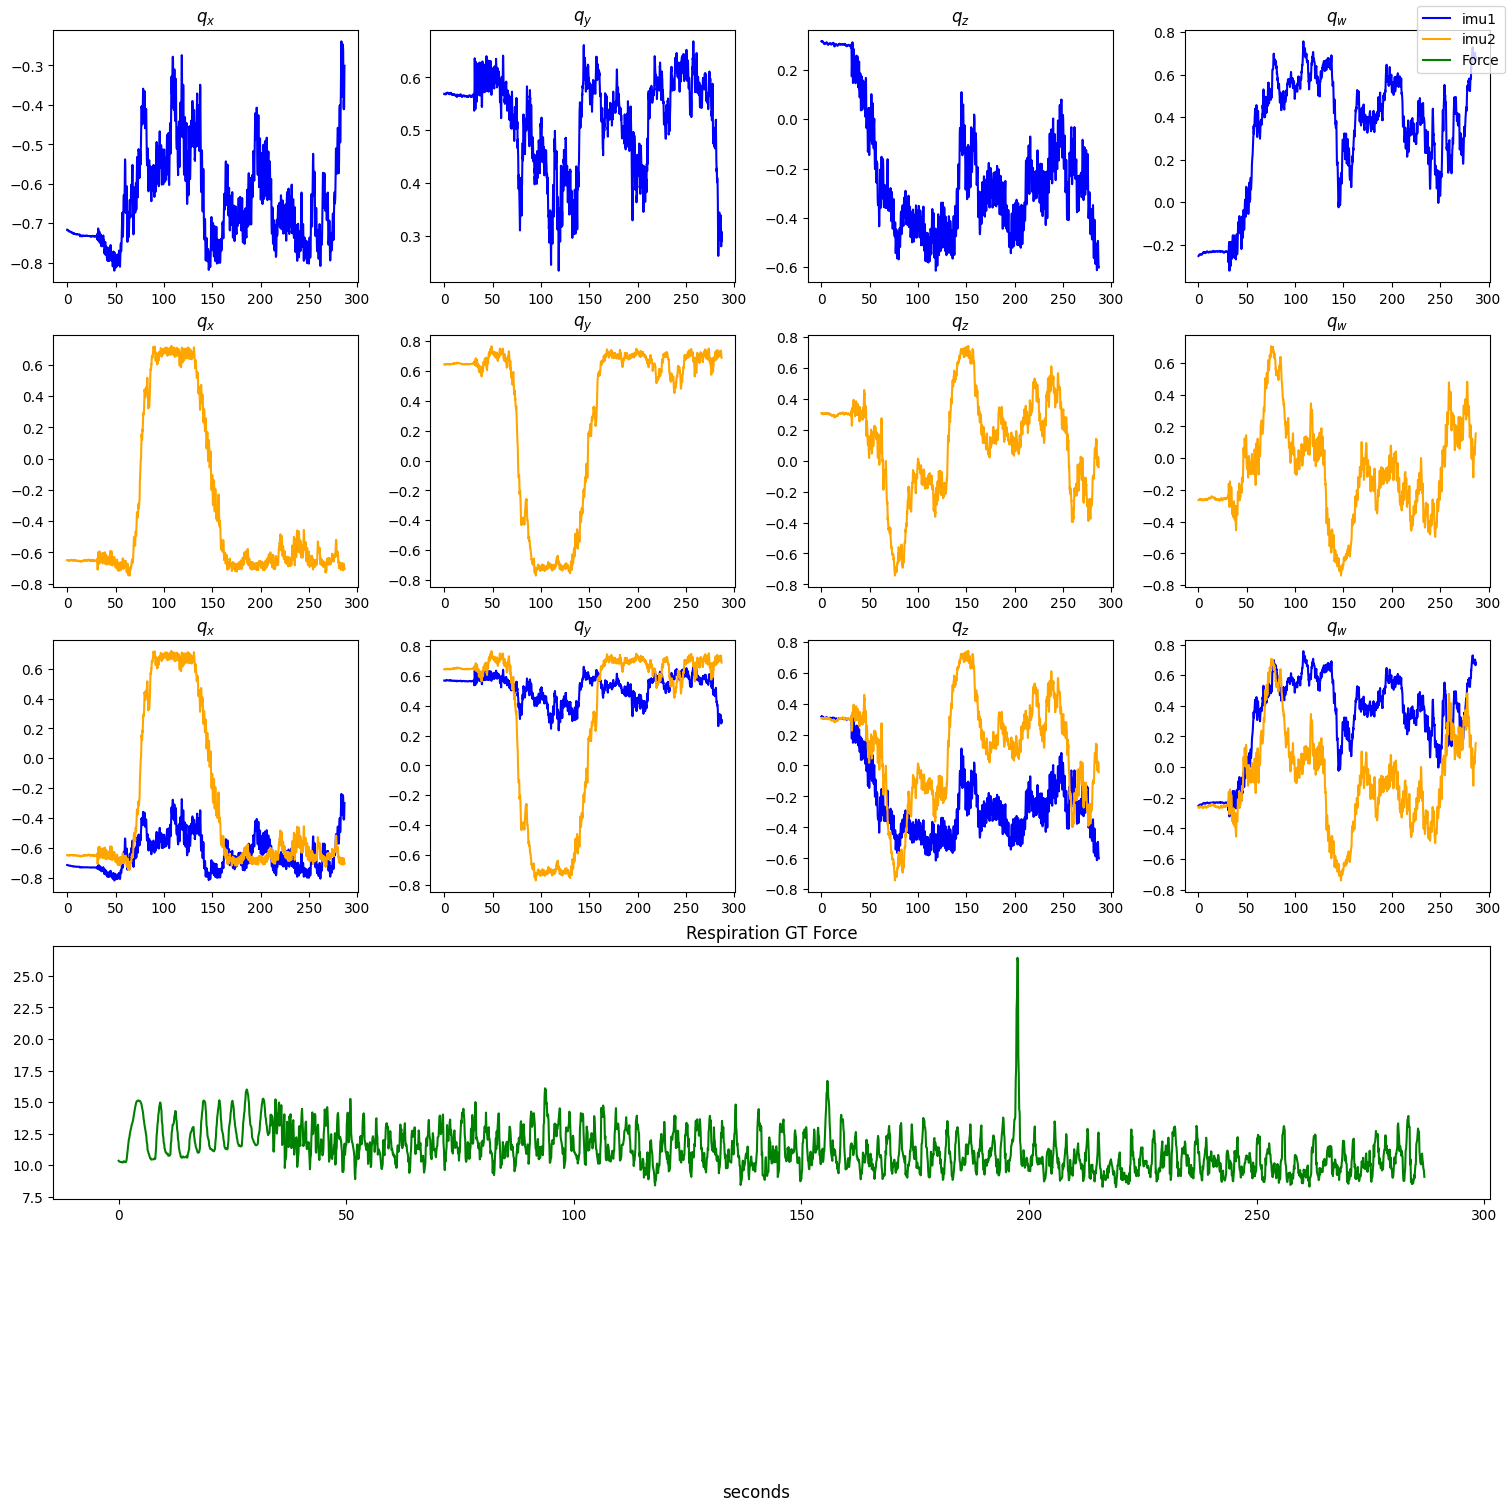

In [2]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

file_path = "./data/2P/test/walk_stand_0407_0852.csv"

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

best_score/total: 300/300


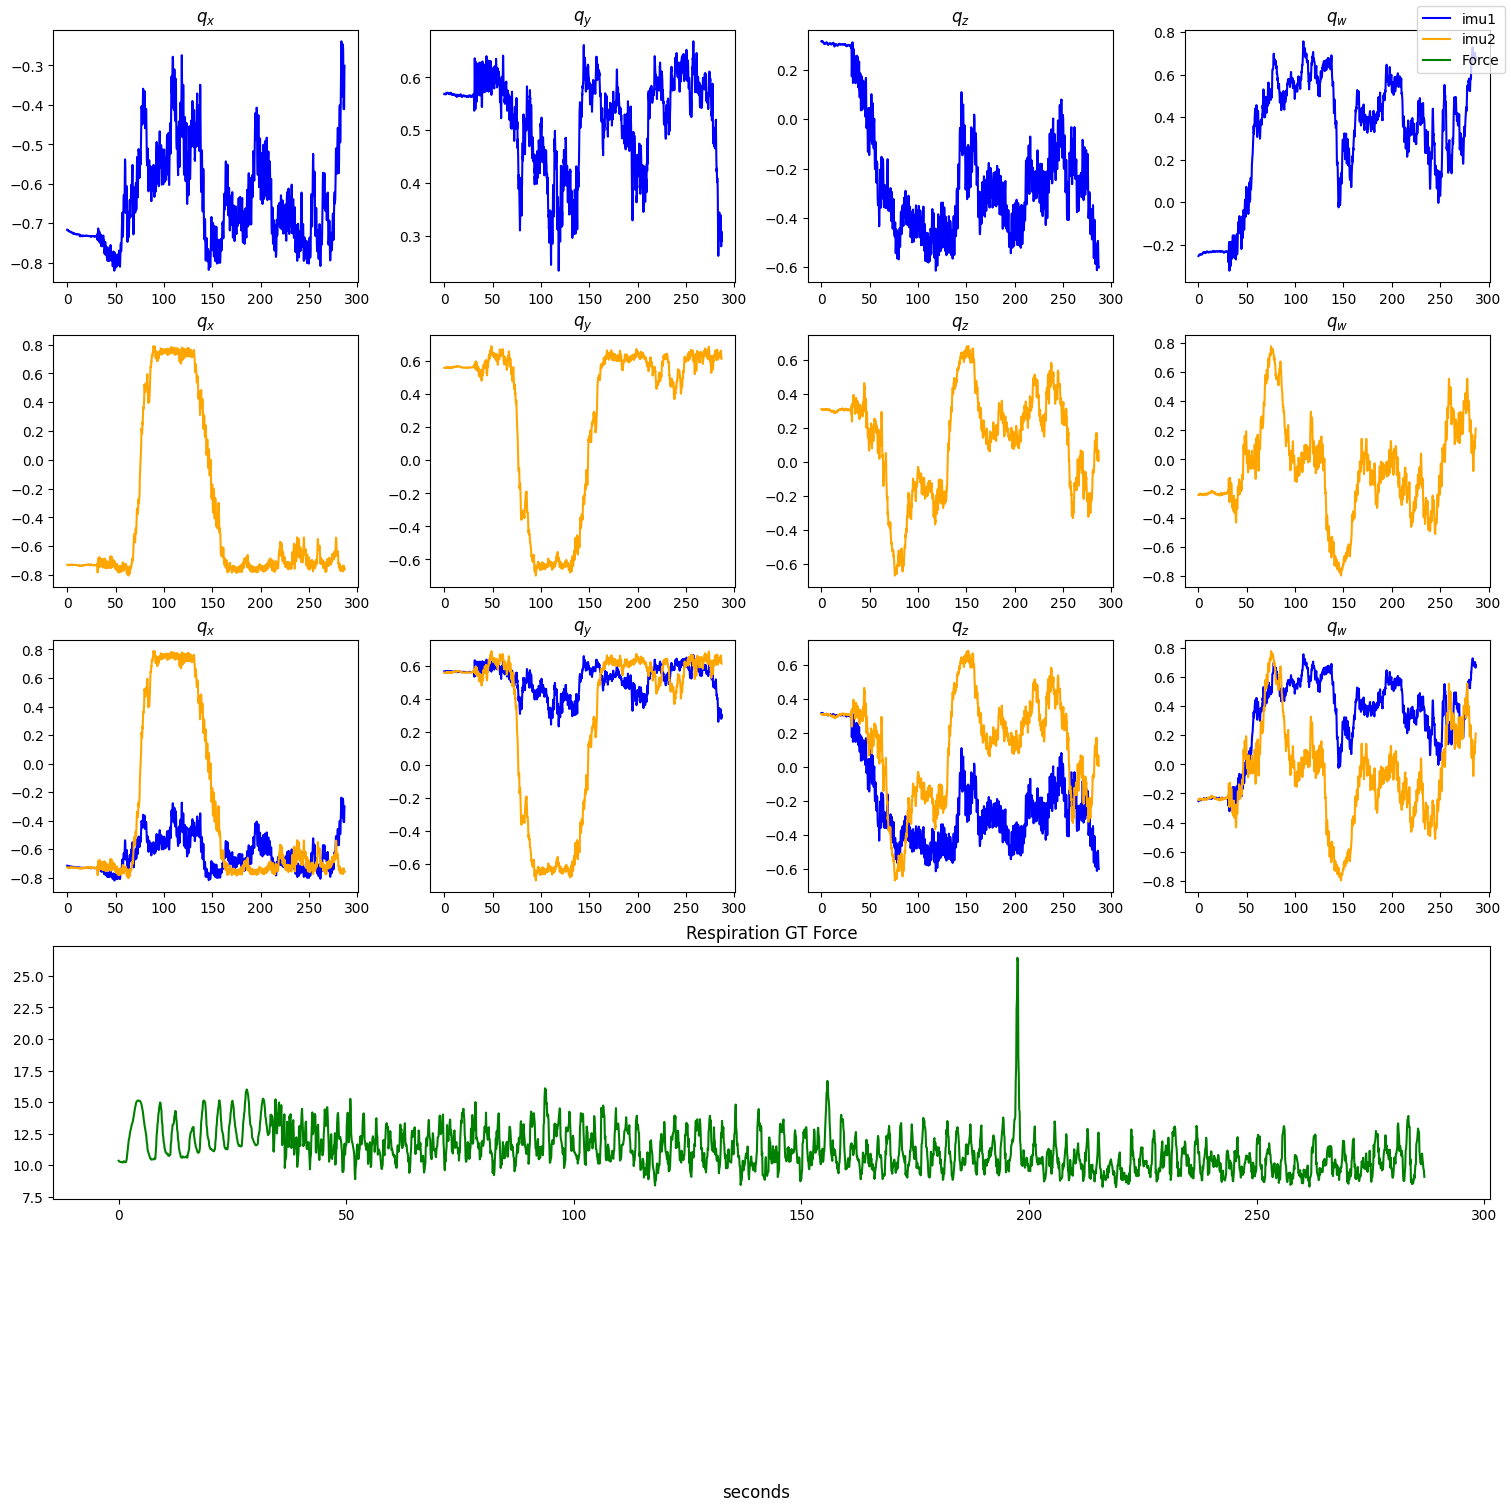

In [3]:
# Align IMUs (IMU2 -> IMU1)
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

draw_imu_curve(data_aligned, overlap=True, show_gt=True)

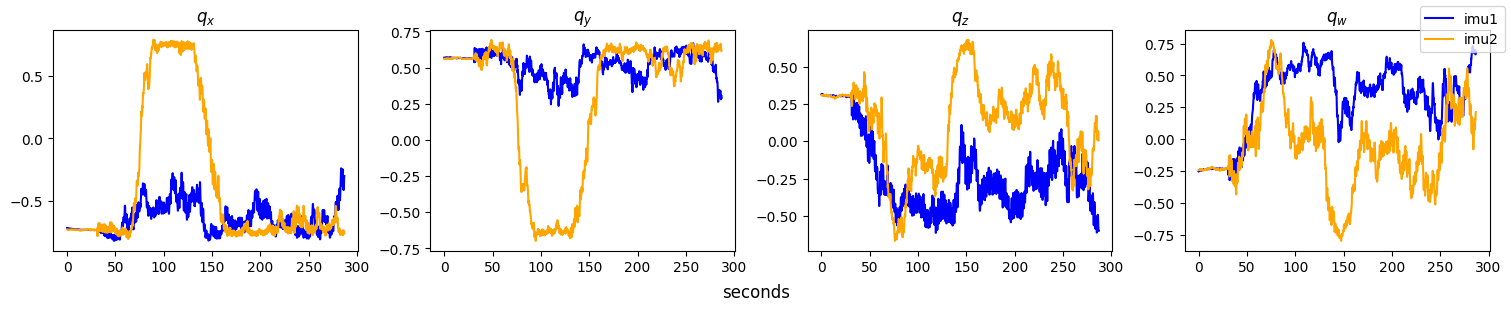

In [4]:
draw_imu_curve(data_aligned, overlap=True, overlap_only=True)

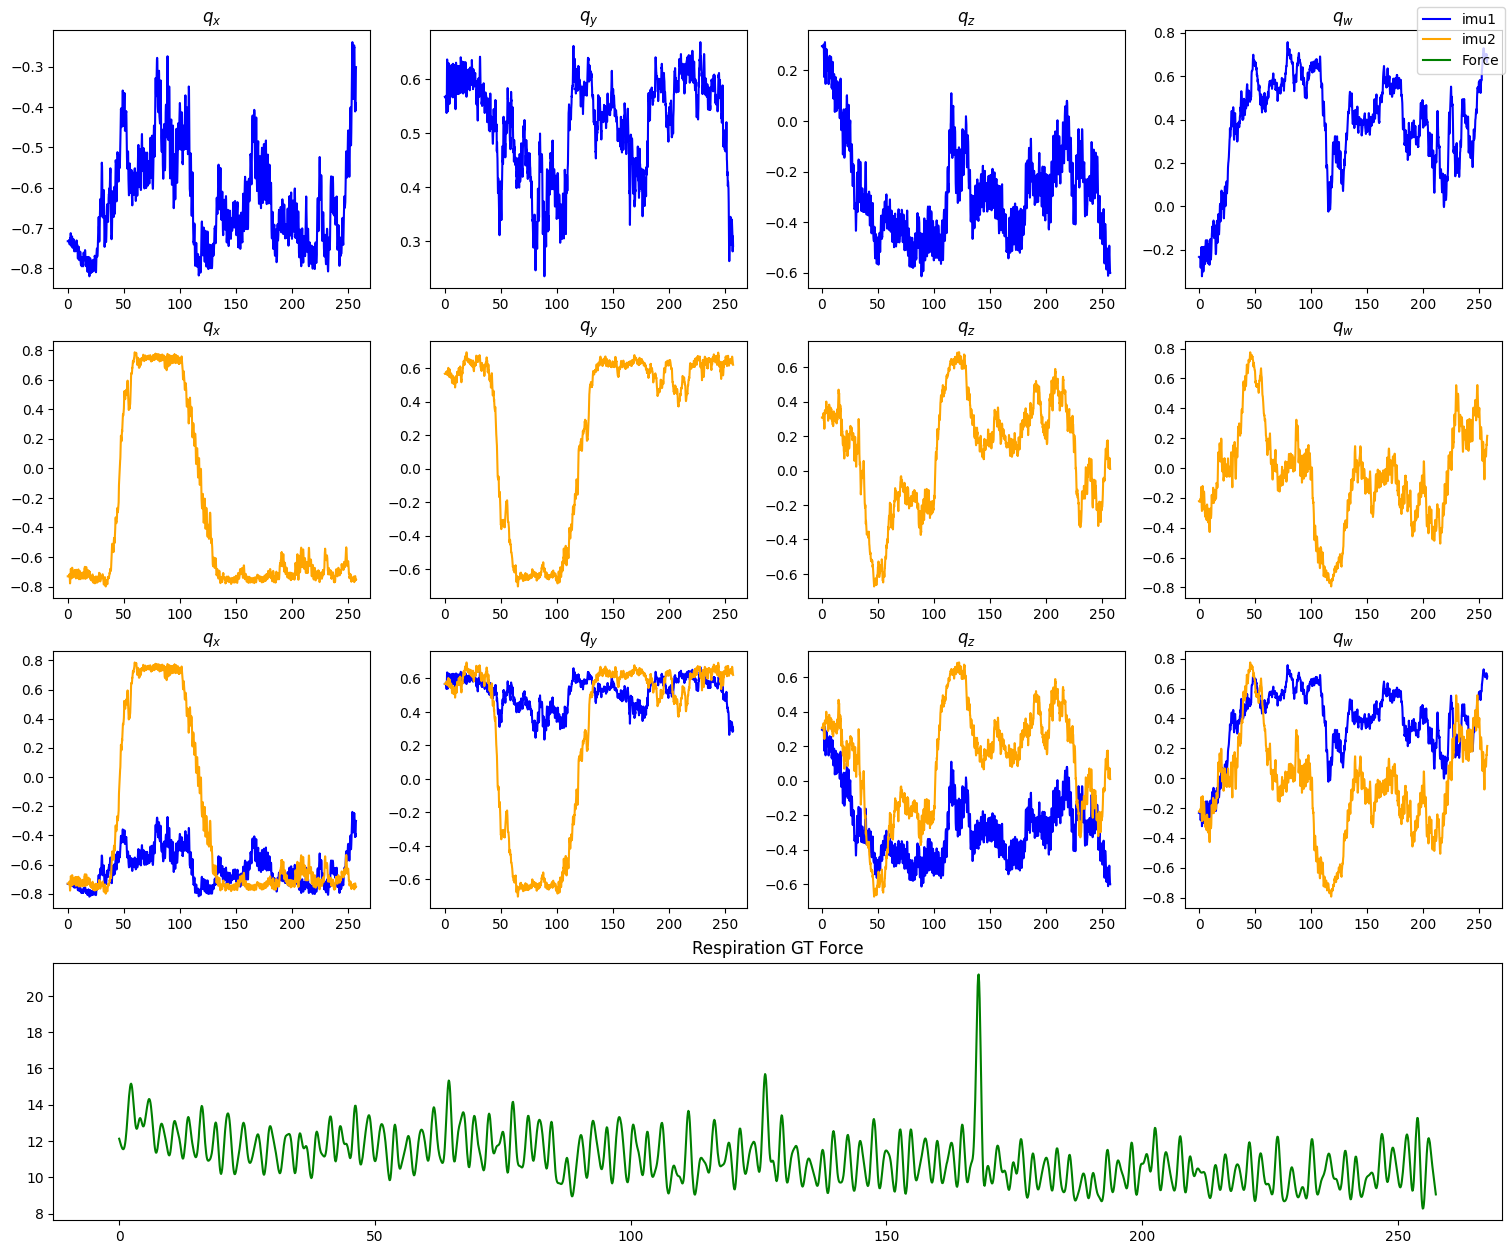

In [5]:
# Handle gt force
data_sp = data_aligned # data used in compute spectrogram shape
data_sp = data_sp[still_pt+0:]
cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion

data_sp.loc[:, "Force"] = butter_filter(data_sp["Force"], cutoff=0.66)
draw_imu_curve(data_sp, overlap=True, show_gt=True)

## Compute Model Parameters (Spectrogram Shape)

In [4]:
file_path = "./data/2P/train/walk_stand_1.csv"

# 1-D spectrogram
# window_size=128
# stride=64
# nperseg=128
# noverlap=64
# out1=True

# 2-D spectrogram
window_size=256
stride=64
nperseg=128
noverlap=64
out1=True

spectrograms_file, gts_file, times_file = prepare_file(file_path, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

num_channels = spectrograms_file.shape[1]
num_freq_bins = spectrograms_file.shape[2]  # From computed spectrogram
num_time_steps = spectrograms_file.shape[3]  # From computed spectrogram

best_score/total: 50/300
----------------------------
sepctrograms:(35, 16, 65, 3)
gt:(35, 1)
times:(35, 1)


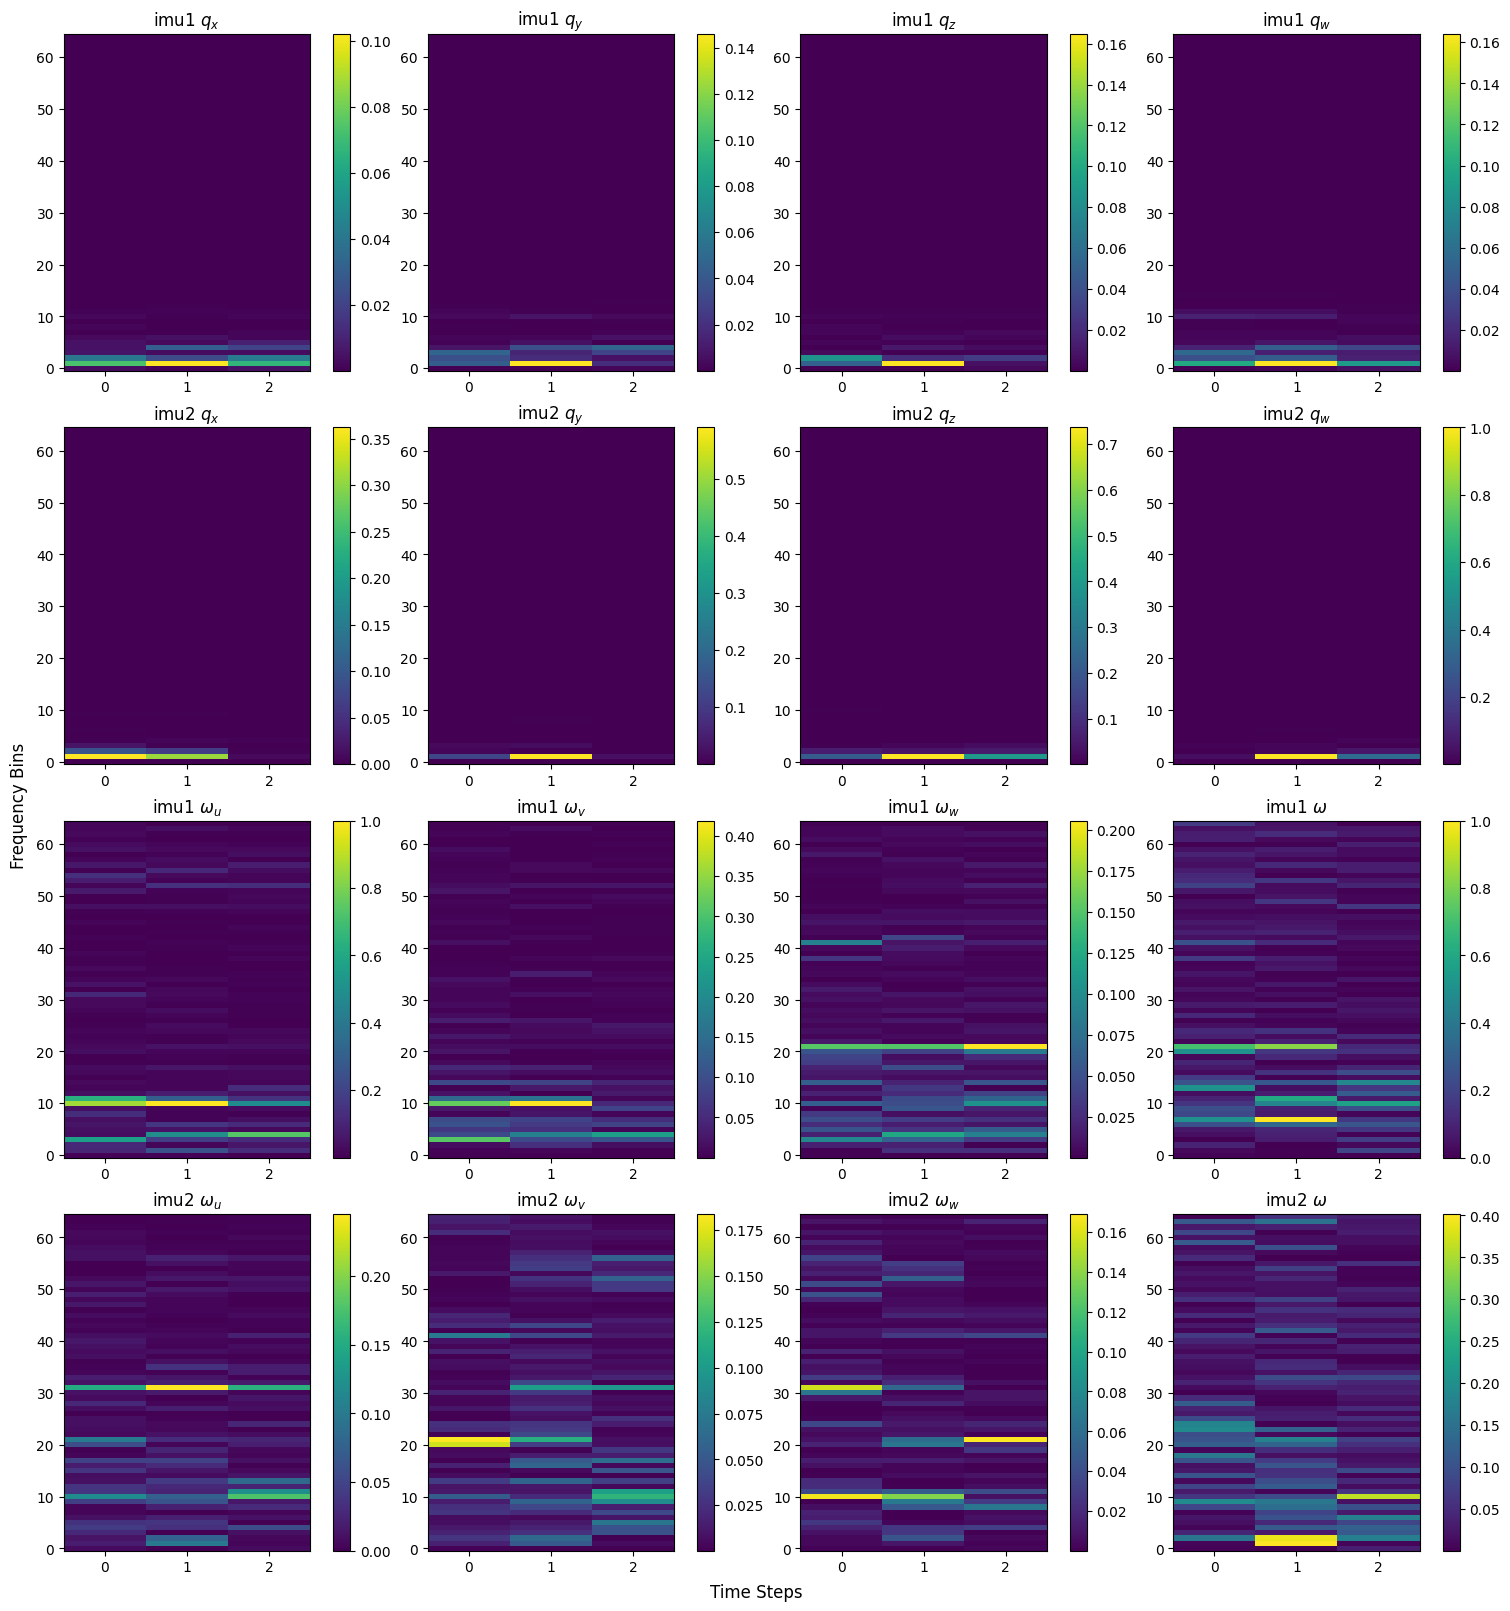

In [5]:
# show one spectrogram
plot_spectrogram_16(spectrograms_file[10])

In [6]:
torch.cuda.is_available()

True

## Prepare Dataset

In [ ]:
# prepare train, testing dataset
path_train = './data/2P/train/'
path_test = './data/2P/test/'
spectrograms_train, gts_train = prepare_data(path_train, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1)
spectrograms_test, gts_test = prepare_data(path_test, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1)

./data/2P/train/mix_1.csv
best_score/total: 145/300
./data/2P/train/mix_2.csv
best_score/total: 215/300
./data/2P/train/mix_3.csv
best_score/total: 42/300
./data/2P/train/run_stand_1.csv
best_score/total: 51/300
./data/2P/train/run_stand_2.csv
best_score/total: 140/300
./data/2P/train/run_stand_3.csv
best_score/total: 259/300
./data/2P/train/run_stand_4.csv
best_score/total: 59/300
./data/2P/train/run_stand_5.csv
best_score/total: 134/300
./data/2P/train/sit_1.csv
best_score/total: 300/300
./data/2P/train/sit_2.csv
best_score/total: 231/300
./data/2P/train/sit_3.csv
best_score/total: 300/300
./data/2P/train/sit_4.csv
best_score/total: 300/300
./data/2P/train/sit_5.csv
best_score/total: 215/300
./data/2P/train/stand_1.csv
best_score/total: 300/300
./data/2P/train/stand_2.csv
best_score/total: 300/300
./data/2P/train/stand_3.csv
best_score/total: 298/300
./data/2P/train/stand_4.csv
best_score/total: 300/300
./data/2P/train/stand_5.csv
best_score/total: 300/300
./data/2P/train/walk_stand_

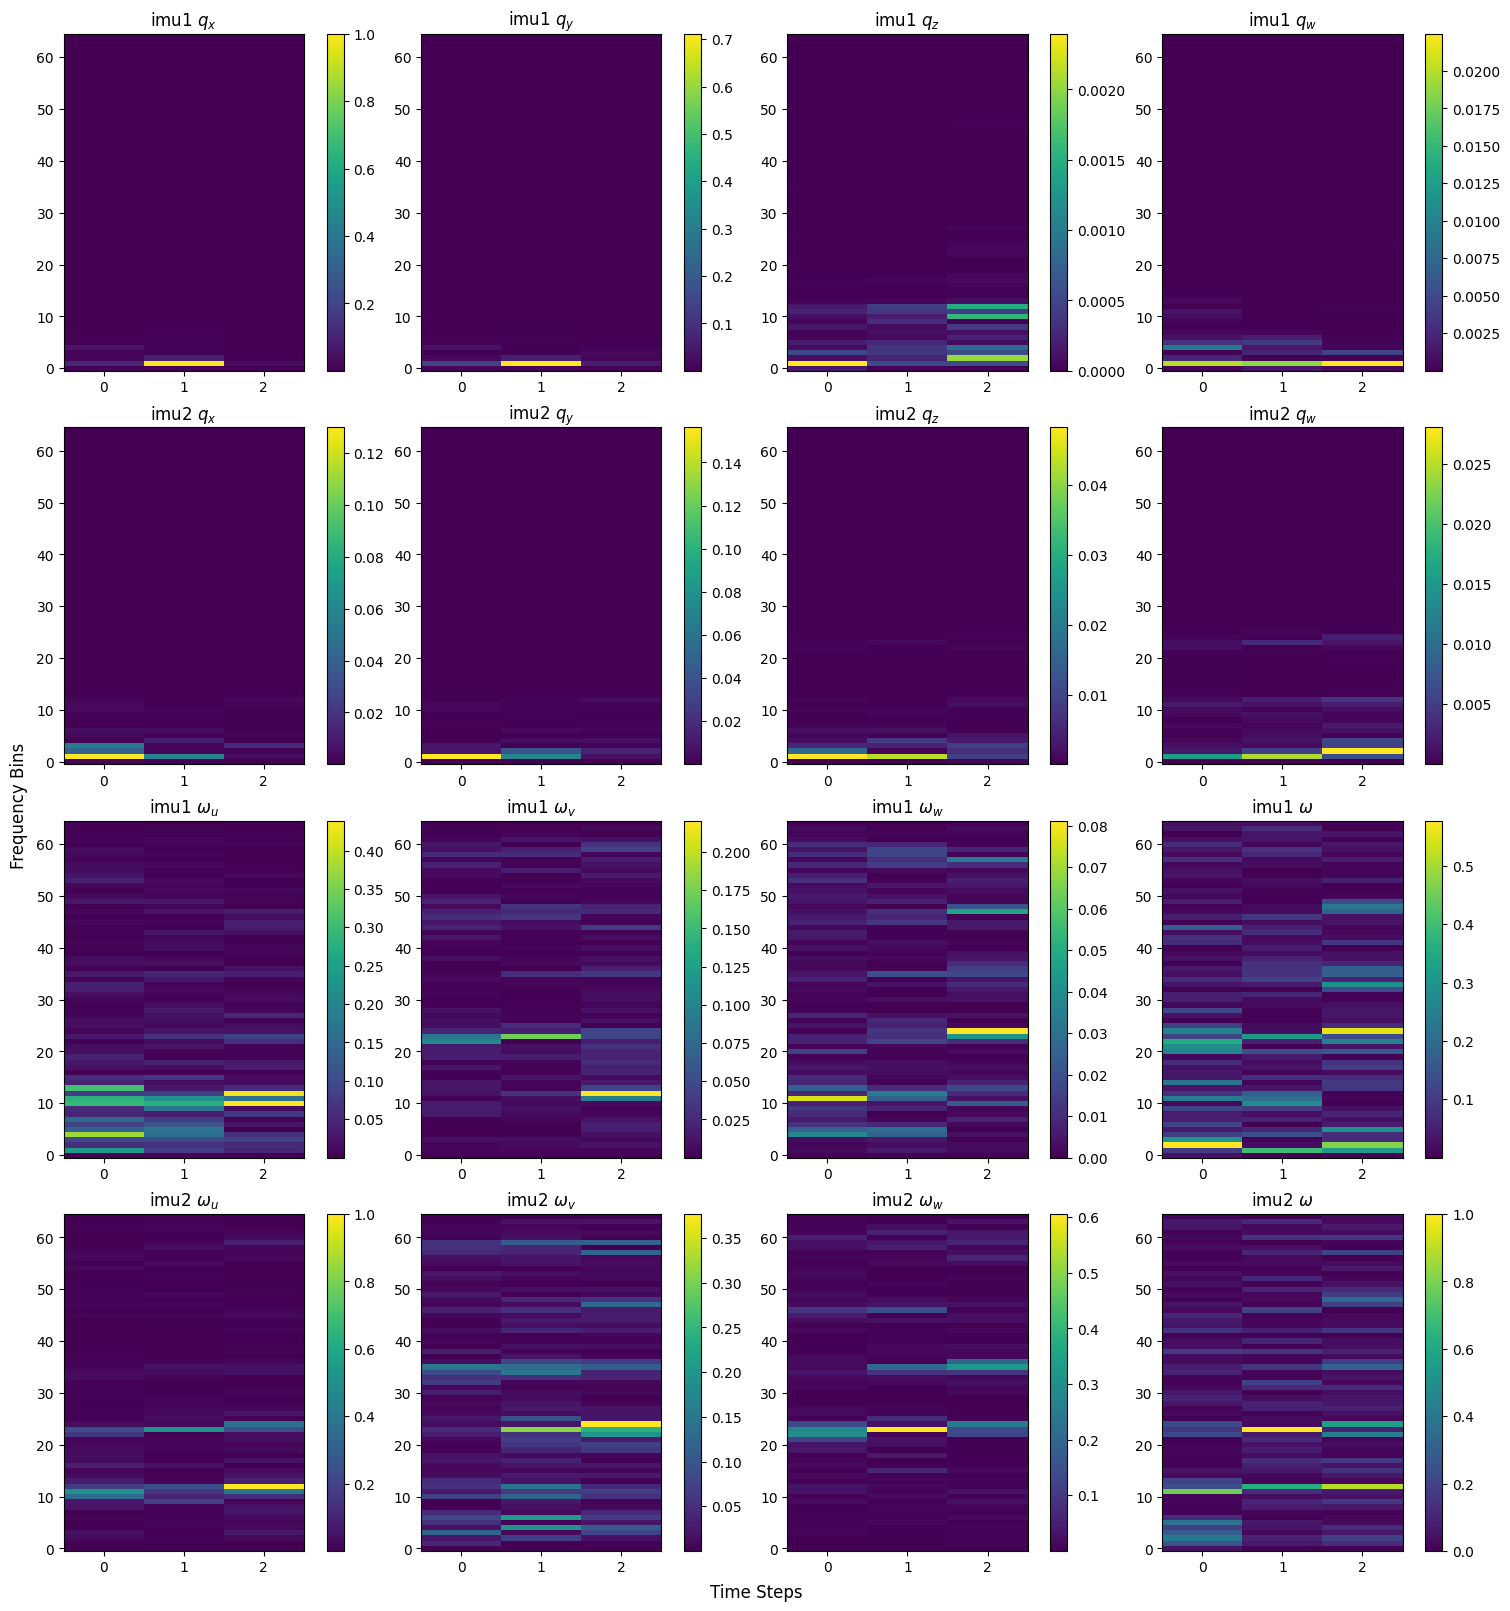

In [ ]:
# show one spectrogram
plot_spectrogram_16(spectrograms_train[0])

## Train Model: Spectrogram with MLP

Epoch 1/100, Train MSE: 0.0063, L1: 3.2060, Test MSE: 0.0059, L1: 3.6803
Epoch 2/100, Train MSE: 0.0013, L1: 1.5956, Test MSE: 0.0062, L1: 3.6365
Epoch 3/100, Train MSE: 0.0008, L1: 1.1994, Test MSE: 0.0042, L1: 2.8933
Epoch 4/100, Train MSE: 0.0005, L1: 0.9243, Test MSE: 0.0030, L1: 2.3546
Epoch 5/100, Train MSE: 0.0005, L1: 0.9040, Test MSE: 0.0026, L1: 2.2566
Epoch 6/100, Train MSE: 0.0005, L1: 0.9021, Test MSE: 0.0028, L1: 2.2899
Epoch 7/100, Train MSE: 0.0004, L1: 0.8025, Test MSE: 0.0026, L1: 2.1944
Epoch 8/100, Train MSE: 0.0003, L1: 0.7315, Test MSE: 0.0020, L1: 1.8943
Epoch 9/100, Train MSE: 0.0003, L1: 0.7289, Test MSE: 0.0025, L1: 2.1796
Epoch 10/100, Train MSE: 0.0003, L1: 0.6687, Test MSE: 0.0026, L1: 2.2132
Epoch 11/100, Train MSE: 0.0002, L1: 0.6055, Test MSE: 0.0023, L1: 2.1293
Epoch 12/100, Train MSE: 0.0002, L1: 0.5613, Test MSE: 0.0027, L1: 2.2204
Epoch 13/100, Train MSE: 0.0002, L1: 0.5588, Test MSE: 0.0025, L1: 2.1144
Epoch 14/100, Train MSE: 0.0002, L1: 0.5431, Te

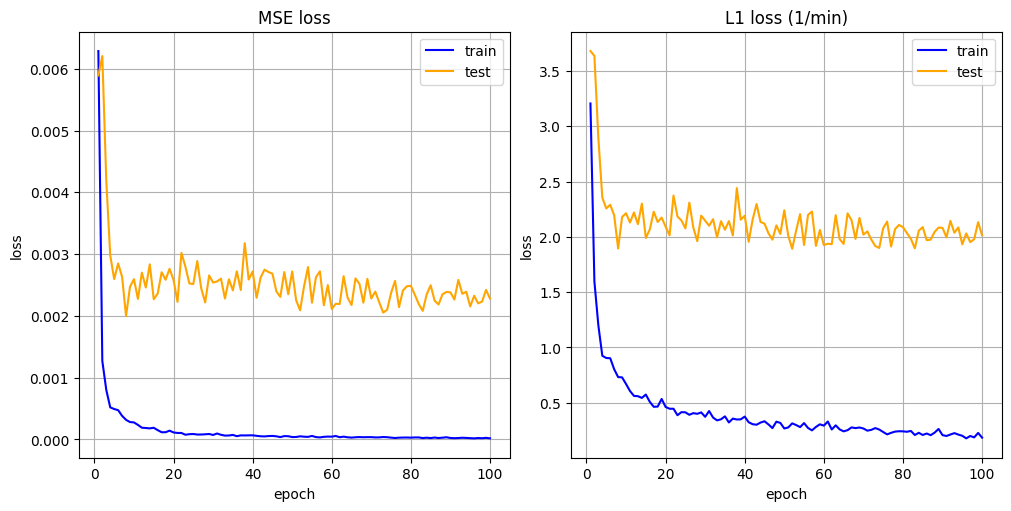

In [ ]:
# Load dataset
# spectrograms_train = np.log(spectrograms_train) # log info
dataset_train = IMUSpectrogramDataset(spectrograms_train, gts_train)
dataset_test = IMUSpectrogramDataset(spectrograms_test, gts_test)
train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True) # batch_size=16
test_loader = DataLoader(dataset_test, batch_size=4, shuffle=True)

# model = MLP(num_freq_bins, num_time_steps, num_channels=num_channels)
model = MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels)
# model = CNN_1D_2(num_channels=num_channels)
# model = CNN_out1_2(num_channels=num_channels)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
now = datetime.now()
model_name = now.strftime("%m%d_%H.%M.%S") # MM_DD_HH:mm:ss
train_model(model, train_loader, test_loader, num_epochs=100, name=model_name, device=device, visualize=True)

## Testing Model

In [7]:
# Load dataset
dataset_dir = "dataset/"
dataset_name = "2P_16_2D" # 2P_16_1D, 2P_16_2D
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']

print('Testing data......')
print(f'Testing shape: {input_test.shape}')

num_channels = input_test.shape[1]
num_freq_bins = input_test.shape[2]
num_time_steps = input_test.shape[3]

dataset_test = IMUSpectrogramDataset(input_test, gt_test)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

# Load model
model_name = 'CNN_2P_2D_2' # MLP_2P_1D, CNN_2P_1D_2, MLP_2P_2D, CNN_2P_2D_2
# model = MLP(num_freq_bins, num_time_steps, num_channels=num_channels)
# model = MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels)
# model = CNN_1D_2(num_channels=num_channels)
model = CNN_out1_2(num_channels=num_channels)

model.load_state_dict(torch.load(f'./models/{str(model_name)}.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate model in whole testing set
mse, mae = evaluate_model(model, test_loader, device=device)

Testing data......
Testing shape: (338, 16, 65, 3)
model Evaluation Results - MSE Loss: 0.0018, L1 Loss: 2.0090 1/min


In [8]:
# Test one file
action_name = "walk_stand_0407_0858" # sit_0407_0746, stand_0407_0816, walk_stand_0407_0852, walk_stand_0407_0858
path_file = f'./data/2P/test/{action_name}.csv'

# spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap)
spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=True)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

best_score/total: 73/300
----------------------------
sepctrograms:(38, 16, 65, 3)
gt:(38, 1)
times:(38, 1)


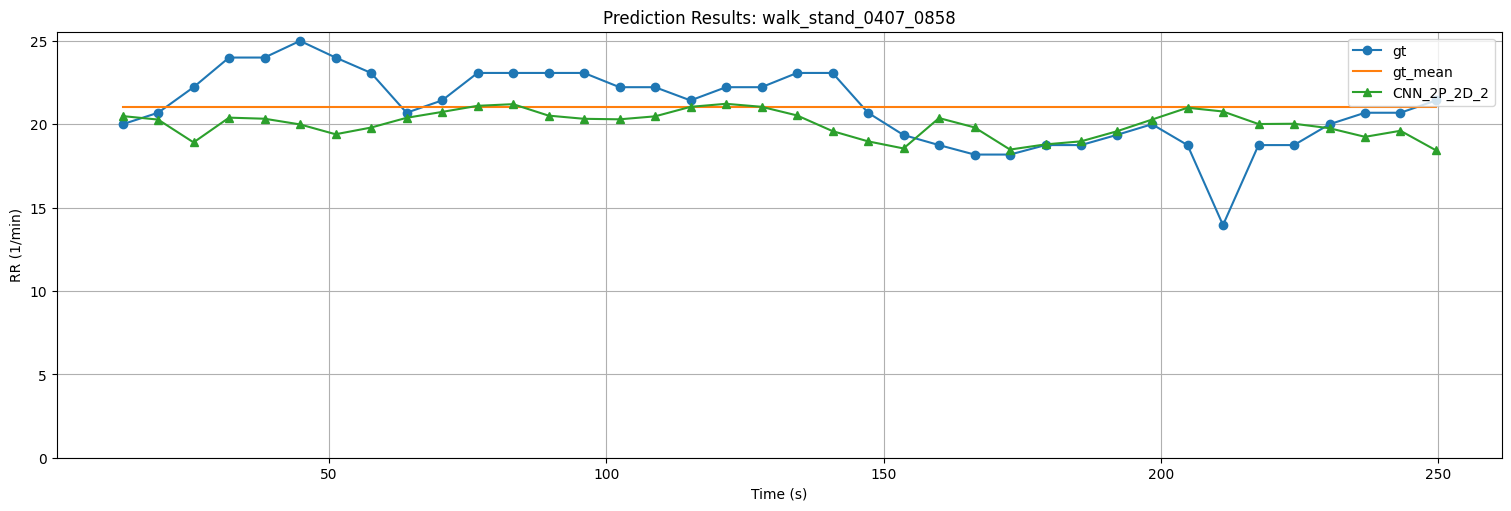

Evaluation Results - MSE Loss: 0.0016, L1 Loss: 1.8677 1/min, R²:-0.1877


In [9]:
avg_mse_loss, avg_l1_loss, preds = evaluate_model_file(model, file_loader, model_name=model_name,gt=gts_file, times=times_file, action_name=action_name)

In [10]:
# Load models
# 1-D spectrogram
# models_name = ['MLP_2P_1D', 'CNN_2P_1D_2']
# models = [MLP(num_freq_bins, num_time_steps, num_channels=num_channels),
#           CNN_1D_2(num_channels=num_channels)]

# 2-D spectrogram
models_name = ['MLP_2P_2D', 'CNN_2P_2D_2', '0417_BiLSTM_2P_2D_lr_0.001', '0417_GRU_2P_2D_lr_0.001']
models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          BiLSTM(num_freq_bins, num_time_steps, num_channels=num_channels),
          GRU(num_freq_bins, num_time_steps, num_channels=num_channels)]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate model in whole testing set
    mse, mae = evaluate_model(models[i], test_loader, model_name=models_name[i], device=device)

MLP_2P_2D Evaluation Results - MSE Loss: 0.0021, L1 Loss: 1.9007 1/min
CNN_2P_2D_2 Evaluation Results - MSE Loss: 0.0018, L1 Loss: 2.0090 1/min
0417_BiLSTM_2P_2D_lr_0.001 Evaluation Results - MSE Loss: 0.0014, L1 Loss: 1.5933 1/min
0417_GRU_2P_2D_lr_0.001 Evaluation Results - MSE Loss: 0.0013, L1 Loss: 1.5465 1/min


MLP_2D Evaluation Results - MSE Loss: 0.0022, L1 Loss: 2.3752 1/min, R²:-0.6328
CNN_2D Evaluation Results - MSE Loss: 0.0016, L1 Loss: 1.8677 1/min, R²:-0.1877
BiLSTM_2D Evaluation Results - MSE Loss: 0.0013, L1 Loss: 1.7394 1/min, R²:0.0298
GRU_2D Evaluation Results - MSE Loss: 0.0017, L1 Loss: 1.9572 1/min, R²:-0.2863


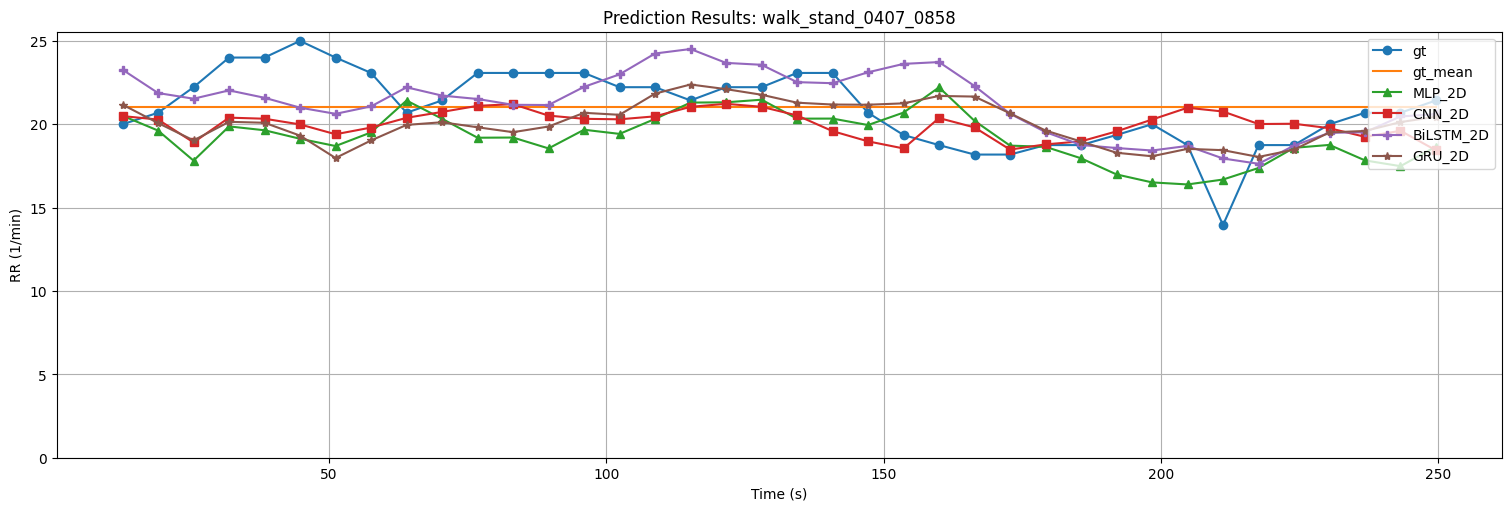

In [ ]:
# avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=["MLP_1D", "CNN_1D"], gt=gts_file, times=times_file, action_name=action_name)
avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=["MLP_2D", "CNN_2D", "BiLSTM_2D", "GRU_2D"], gt=gts_file, times=times_file, action_name=action_name)

## Testing Actions

In [2]:
# Load dataset
dataset_dir = "dataset/action"
dataset_name = "2P_16_2D" # 2P_16_1D, 2P_16_2D
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

first_key = next(iter(input_test))
num_channels = input_test[first_key].shape[1]
num_freq_bins = input_test[first_key].shape[2]
num_time_steps = input_test[first_key].shape[3]

print('Testing data......')
for k, v in input_test.items():
    print(f'action: {k}')
    # print(f'input_test[{k}]:{input_test[k].shape}')
    # print(f'gt_test[{k}]:{gt_test[k].shape}')

Testing data......
action: sit
action: stand
action: walk


In [3]:
# 2-D spectrogram
models_name = ['MLP_2P_2D', 'CNN_2P_2D_2', '0417_BiLSTM_2P_2D_lr_0.001', '0417_GRU_2P_2D_lr_0.001']
models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          BiLSTM(num_freq_bins, num_time_steps, num_channels=num_channels),
          GRU(num_freq_bins, num_time_steps, num_channels=num_channels)]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MLP_2D
sit - MSE Loss: 0.0005, L1 Loss: 0.7647 1/min
stand - MSE Loss: 0.0010, L1 Loss: 1.3922 1/min
walk - MSE Loss: 0.0048, L1 Loss: 3.5182 1/min

CNN_2D
sit - MSE Loss: 0.0010, L1 Loss: 1.4659 1/min
stand - MSE Loss: 0.0020, L1 Loss: 2.2214 1/min
walk - MSE Loss: 0.0023, L1 Loss: 2.3340 1/min

BiLSTM_2D
sit - MSE Loss: 0.0005, L1 Loss: 0.7716 1/min
stand - MSE Loss: 0.0011, L1 Loss: 1.5447 1/min
walk - MSE Loss: 0.0025, L1 Loss: 2.4483 1/min

GRU_2D
sit - MSE Loss: 0.0005, L1 Loss: 0.9152 1/min
stand - MSE Loss: 0.0008, L1 Loss: 1.2455 1/min
walk - MSE Loss: 0.0027, L1 Loss: 2.4640 1/min



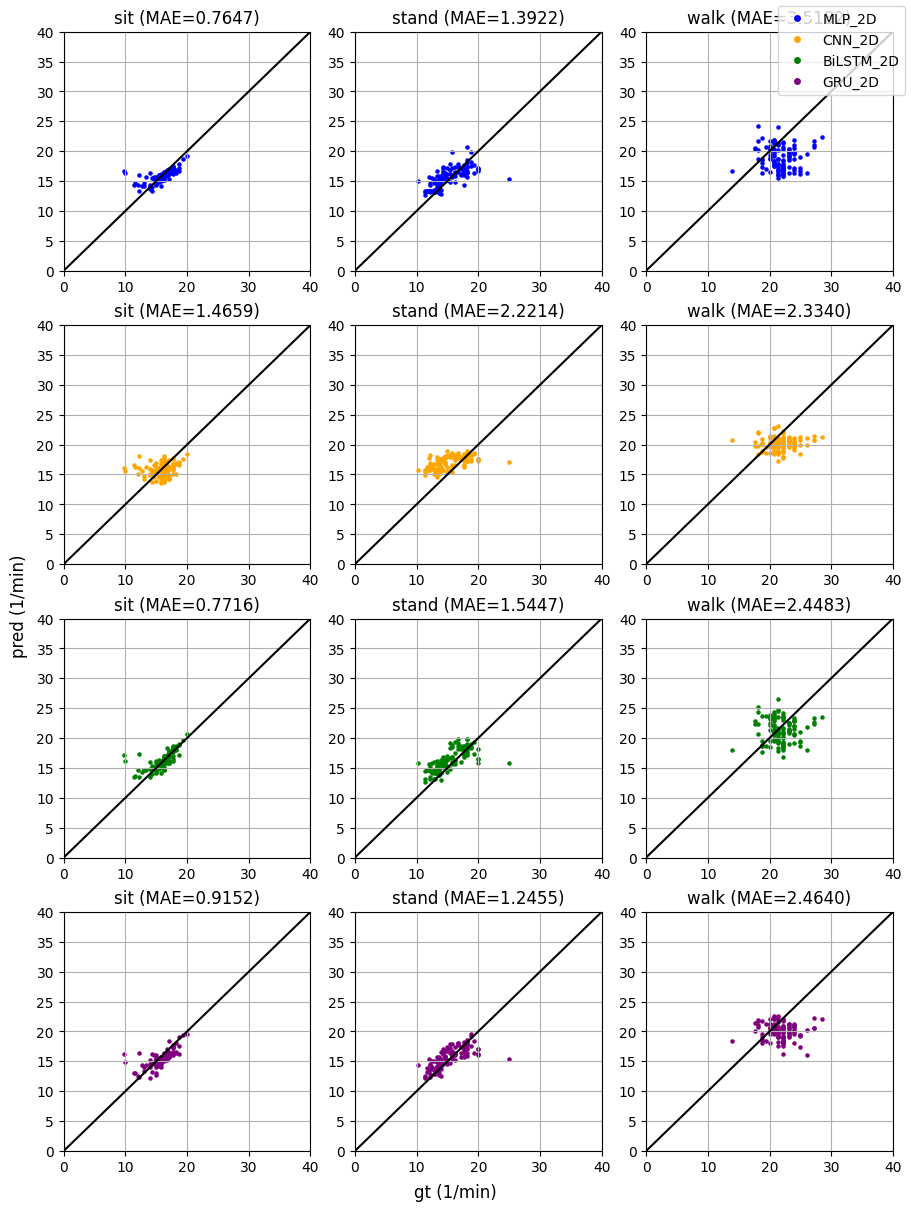

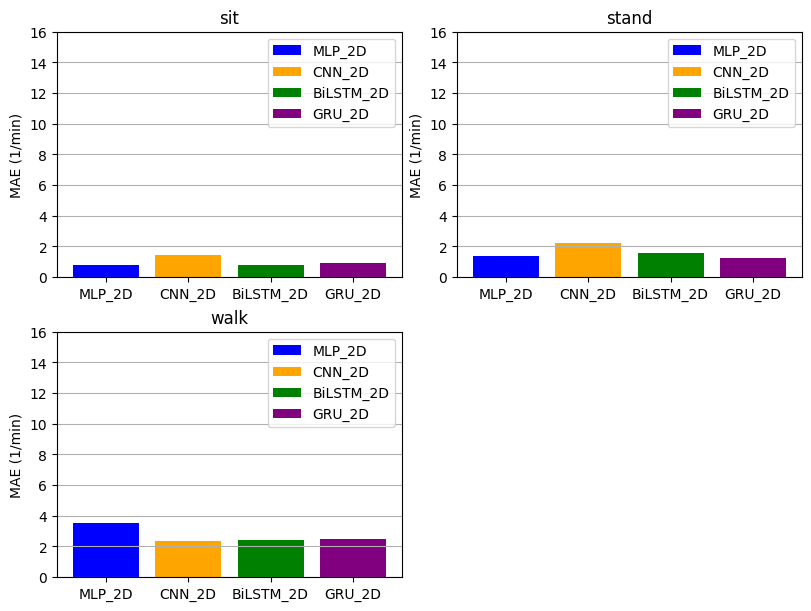

In [4]:
evaluate_models_action(models, input_test, gt_test, models_name=["MLP_2D", "CNN_2D", "BiLSTM_2D", "GRU_2D"], device=device, visualize=True)

MLP_2D
sit - MSE Loss: 0.0005, L1 Loss: 0.7647 1/min E%: 5.4897%
stand - MSE Loss: 0.0010, L1 Loss: 1.3922 1/min E%: 9.2526%
walk - MSE Loss: 0.0048, L1 Loss: 3.5182 1/min E%: 15.7156%

CNN_2D
sit - MSE Loss: 0.0010, L1 Loss: 1.4659 1/min E%: 9.9789%
stand - MSE Loss: 0.0020, L1 Loss: 2.2214 1/min E%: 15.8532%
walk - MSE Loss: 0.0023, L1 Loss: 2.3340 1/min E%: 10.4622%

BiLSTM_2D
sit - MSE Loss: 0.0005, L1 Loss: 0.7716 1/min E%: 5.5785%
stand - MSE Loss: 0.0011, L1 Loss: 1.5447 1/min E%: 10.5641%
walk - MSE Loss: 0.0025, L1 Loss: 2.4483 1/min E%: 11.2820%

GRU_2D
sit - MSE Loss: 0.0005, L1 Loss: 0.9152 1/min E%: 6.2538%
stand - MSE Loss: 0.0008, L1 Loss: 1.2455 1/min E%: 8.2464%
walk - MSE Loss: 0.0027, L1 Loss: 2.4640 1/min E%: 10.9775%



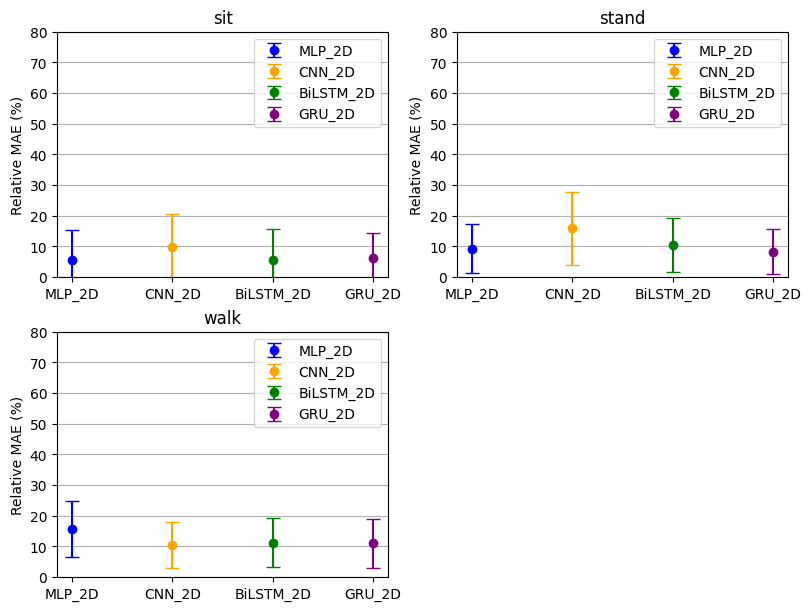

In [5]:
evaluate_models_action_relative(models, input_test, gt_test, models_name=["MLP_2D", "CNN_2D", "BiLSTM_2D", "GRU_2D"], device=device, visualize=True)